In [62]:
'''
    STOCHASTIC OPTIMIZATION
    Cross-entropy method
    
    Last reviewed: 02/12/2018
    @author: Gabriel Moreira
'''

%matplotlib inline
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import matplotlib.patches as mpatches
plt.rcParams["animation.html"] = "jshtml"

font = {'family' : 'serif',
        'weight' : 'light',
        'size' : 9.5}

matplotlib.rc('font', **font)

# Stochastic Optimization

## 1. Cross Entropy method application example

### 1.1. The Combinatorial Optimization Problem

Consider a binary vector $Y = (y_1, y_2, ..., y_n)$. $Y$ is unknown, but we can compare it to another vector $X$ by means of a performance function $S(x)$.

The perfomance function $S(X)$ is defined as follows:

$$
    S(X) = n - \sum_{i=1}^N\vert{x_j-y_j}\vert
$$

And it represents the number of matches between the vectors $Y$ and $X$.

### 1.2. The Algorithm

1. Define $\hat{p}_{0} = \big[\frac{1}{2}, \frac{1}{2}, ..., \frac{1}{2}\big]$. Set $t = 0$, 

2. Increment $t$. Draw $N$ random sample vectors $X_1, ...X_N$ from a Bernoulli distribution of probability $\hat{p}_{t-1}$. The variables $X_{1,1}, X_{1,2}, ..., X_{1,n}$ are observations of $n$ independant random variables that follow Bernoulli distributions of parameters $\hat{p}_{t,1}, \hat{p}_{t,2}, ..., \hat{p}_{t,n}$, respectively.

3. Calculate performances $S(X_i)$. Sort the performances and set a quantile $\rho$. Define $\hat{\gamma}_t = S_{(1-\rho)N}$. This threshold allows us to use the samples with best performances when calculating the probability distributions for the next iteration.

4. Calculate $\hat{p}_t$ as:

$$ 
    \hat{p}_{t,j} = \frac{\sum_{i=1}^{N} \mathbb{1}(S(X_i)\geq \hat{\gamma}_t)\mathbb{1}(X_{i,j}=1)}{\sum_{i=1}^{N}\mathbb{1}(S(X_i)\geq \hat{\gamma}_t)}
$$

5. Stop if stopping criterion is met. Otherwise increment $t$ by 1.

### 1.3. Application in Python

In [63]:
'''
    Defines the problem, with the hidden y binary vector.
    Performance function to evaluate how close the vector x
    is to the hidden vector y.
    If y = x then the performance is the length of y.
'''
class optimizationProblem:
    
    def __init__(self, y):
        self.y = y # secret binary vector
        self.vector_size = len(y)
        
    def performance(self, x):
        # Performance
        s = self.vector_size - abs(np.subtract(x,self.y)).sum()
        return s

'''
    Solves the optimization problem specified with:
    - vector_size: length of the binary vector.
    - max_iter: max number of iterations allowed.
    - num_samples: number of random samples generated at each iteration.
'''
def solve(problem, max_iter, num_samples):
    '''
        Initialize a probability vector
    '''
    vector_size = problem.vector_size
    p_hat = []
    p_hat_0 = np.array([0.5]*vector_size)
    p_hat.append(p_hat_0)
    
    for t in range(max_iter):
        '''
            Generate samples X from the probability distribution
            of the previous iteration, and calculate their performances S.
        '''
        X = []
        S = [] 
        for j in range(num_samples):
            X.append(np.random.binomial(size=vector_size, n=1, p=p_hat[t]))
            S.append(problem.performance(X[j]))

        values = zip(S,X)
        sorted_samples = sorted(values, key = lambda t : t[0])
        
        '''
            Select the samples with the best performances.
            Keeps the quantile (1-rho)
        '''
        rho = 0.6
        upper_bound = int(rho*num_samples)
        del sorted_samples[:upper_bound]
        
        '''
            Calculate the new probability distribution
        '''
        cumsum = np.array([0]*vector_size)
        for j in range(len(sorted_samples)):
            cumsum = np.add(cumsum, sorted_samples[j][1])
        new_p_hat = cumsum/(num_samples-upper_bound) # new probability vector
        
        '''
            Verifies if the probability vector has converged.
            If so, stop and present the solution.
        '''
        if (new_p_hat == p_hat[t]).all() and sorted_samples[len(sorted_samples)-1][0] == vector_size:
            print('> Solution found!')
            print('> %d iterations.' % t)
            return p_hat
        else:
            p_hat.append(new_p_hat)
            
    print('> Could not find a solution.')

In [64]:
y = np.array([1,1,0,1,1,0,1,0,0,0,0,1,0,0,1,0,0,0,1,0,
              1,1,0,1,1,0,1,1,0,1,0,1,1,1,1,1,0,0,1,0,
              1,1,0,1,1,0,1,0,0,0,1,0,1,0,1,0,0,0,1,0])

problem = optimizationProblem(y)
p = solve(problem, max_iter=200, num_samples=40)

> Solution found!
> 15 iterations.


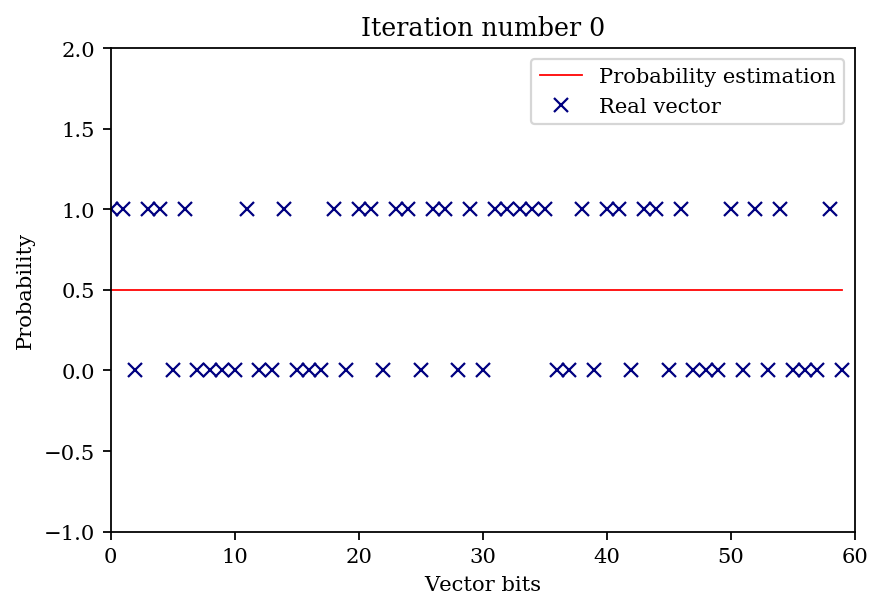

In [65]:
'''
    Code for the animation showing the 
    probabilities vector converging to 
    the hidden binary vector y
'''

fig = plt.figure(dpi=160)
ax = fig.add_subplot(111, xlim=(0, len(y)), ylim=(-1, 2))
line, = ax.plot([], [], 'r-', linewidth=0.8)

def init():
    """initialize animation"""
    line.set_data([], [])
    return line

def update_line(i):
    line.set_data(np.arange(len(p[0])), p[i])
    ax.plot(np.arange(len(p[0])), y, 'x', color='navy')
    ax.set_title('Iteration number ' + str(i))
    ax.set_xlabel('Vector bits')
    ax.set_ylabel('Probability')
    ax.legend(['Probability estimation','Real vector'])
    return line,

ani = animation.FuncAnimation(fig, update_line, frames=len(p), interval=400);

In [66]:
'''
    Shows animation
'''

ani